# **Israel Elections Data Analysis - Lab 4**


**Daniel Ohayon - ID: 315453027**

**Olga Moroz - ID: 324756568**

### **environment checking**

In [2]:
# Add a check if we run in google colab or locally in jupyter notebook
run_in_colab = True
if 'google.colab' in str(get_ipython()):
    run_in_colab = True
    print('Running on CoLab')
else:
    print('Running locally on Jupyter')

Running on CoLab


### **Import modules**

In [3]:
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
import os
import io
from matplotlib import pyplot as plt
import numpy.matlib as mtl
import copy
import random
import statsmodels.api as sm


%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Import data**

In [4]:
# Mount drive in google colab
if run_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')

data_path = "C:/Users/Daniel Ohayon/PycharmProjects/Statistics Lab" 

Mounted at /content/drive


In [5]:
# Loading elections 2020 elections data:
if run_in_colab:
    from google.colab import files
    uploaded = files.upload()

Saving Eshkol Hevrati Calcali.csv to Eshkol Hevrati Calcali.csv
Saving votes per ballot 2020.csv to votes per ballot 2020.csv
Saving votes per city 2020.csv to votes per city 2020.csv


In [6]:
import io

df_2020_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2020_raw = df_2020_raw.drop(['מעטפות חיצוניות'], axis=0)
# preprocessing of ballot
df_2020 = df_2020_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
df_2020 = df_2020[df_2020.columns[9:]] # removing "metadata" columns

# Dataset is now stored in a Pandas Dataframe

In [7]:
df_2020

,אמת,ג,ודעם,ז,זך,זץ,טב,י,יז,ינ,יף,יק,יר,כ,כן,ל,מחל,נ,נז,ני,נץ,נק,פה,ףז,ץ,ק,קי,קך,קץ,שס
שם ישוב,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
אבו גווייעד שבט,2,0,112,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0,0,0,2
אבו גווייעד שבט,6,0,235,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,2,0
אבו גווייעד שבט,5,0,207,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,2,1,0,0,0,0,0,0
אבו גוש,15,1,229,0,0,0,0,0,0,1,0,0,1,0,0,0,32,0,0,0,0,0,11,0,0,0,0,0,0,2
אבו גוש,6,0,330,0,0,0,0,0,0,2,0,0,0,0,0,2,23,0,0,0,0,0,18,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
תקוע,10,14,2,3,0,0,174,0,0,0,0,0,0,1,1,15,227,0,0,0,9,0,27,0,0,0,0,1,0,11
תקוע,7,8,0,1,0,0,301,0,0,0,0,0,0,0,0,10,188,2,0,0,9,0,25,1,0,1,0,1,4,13
תראבין אצאנע שבט,0,0,43,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0


# **Preliminary calculations from lab 2**

### **Computing votes share only for parties above a certain threshold, and creating a dataframe fo them:**

In [8]:
def parties_votes_percents(df, thresh):
    par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
    return par[par >= thresh]

top_parties = parties_votes_percents(df_2020, 0.0325)  # finding the top 8 parties

In [9]:
par_letters = top_parties.keys()
top_par_df = df_2020_raw[par_letters]    
top_par_df

,מחל,פה,ודעם,שס,ג,ל,אמת,טב
שם ישוב,,,,,,,,
אבו גווייעד שבט,1,6,112,2,0,0,2,0
אבו גווייעד שבט,2,0,235,0,0,0,6,0
אבו גווייעד שבט,1,2,207,0,0,1,5,0
אבו גוש,32,11,229,2,1,0,15,0
אבו גוש,23,18,330,0,0,2,6,0
...,...,...,...,...,...,...,...,...
תקוע,227,27,2,11,14,15,10,174
תקוע,188,25,0,13,8,10,7,301
תראבין אצאנע שבט,0,4,43,0,0,0,0,0


Create a dictionary of the parties:

In [10]:
party_names = { "מחל" : "הליכוד", "פה" : "כחול לבן", "ודעם" : "הרשימה המשותפת" , "שס" : "שס" ,
               "ג" : "יהדות התורה", "ל" : "ישראל ביתנו", "אמת" :  "העבודה גשר מרצ",  "טב" : "ימינה"  }

### **The simulation function:**

In [11]:
def sample_bin(v_ij, n_ij_t):
  v_ij[v_ij > 1] = 1
  v_ij[v_ij < 0 ] = 0
  simulation = np.empty((n_ij_t.shape[0],n_ij_t.shape[1]))
  for ballot in range(n_ij_t.shape[0]):  
      for party in range(n_ij_t.shape[1]):
          simulation[ballot,party] = np.random.binomial(n_ij_t[ballot,party], v_ij[ballot,party])
  return simulation

### **:פונקציה להמרת מטריצה לדאטה פריים לשם הנוחות**

In [12]:
def numpy_to_df (matrix):
  matrix = pd.DataFrame(matrix)
  matrix.index = top_par_df.index
  matrix.columns = top_par_df.columns
  return matrix

### **calculating nij tilde** 

In [13]:
# multiplying the number of voters by correct ratio
n_ij_t = copy.deepcopy(top_par_df)
fixed_ratio = (df_2020_raw["בזב"].sum())/(df_2020_raw['כשרים'].sum())
n_ij_t=round(n_ij_t.mul(fixed_ratio,axis=0))

n_ij_t = n_ij_t.to_numpy()   # To multiply matrices


###**calculating 3 vij for the simulations:**

vij = vi

In [14]:
vi = df_2020_raw["כשרים"]/df_2020_raw['בזב']
v_mi = np.asmatrix(vi)
vi = mtl.repmat(v_mi,8,1)
vi = vi.transpose()

vij = uj

In [15]:
uj_percents = {"מחל" : 0.9  , "פה" : 0.8 , "ודעם" : 0.7 , "שס" : 0.6 ,
               "ג" : 0.5 , "ל" : 0.4, "אמת" : 0.3 ,  "טב" : 0.2  }
uj = list(uj_percents.values())
u_m= np.asmatrix(uj)
uj = mtl.repmat(u_m,10631,1)

vij = random uj

In [16]:
rnd_uj_df = np.empty((top_par_df.shape[0],top_par_df.shape[1]))  ## dataframe for the resuls
city_list= top_par_df.index.values.tolist() # list of the cities by the 'שם הישוב'

last_city = 's'  # random letter for the firsct checking
rand_order = list(uj_percents.values())
for i in range(0, len(city_list)):
  if last_city == city_list[i]:
      rnd_uj_df[i,] = rand_order
  else: 
      random.shuffle(rand_order)
      rnd_uj_df[i,] = rand_order
      last_city = city_list[i]

### **מימוש הסימולציות**

:סימולציות ללא תיקון

In [17]:
nij_vi, nij_uj, nij_rnd_uj = [],[],[]

for i in range(50):
  nij_vi.append(sample_bin(vi,n_ij_t))
  nij_uj.append(sample_bin(uj,n_ij_t))
  nij_rnd_uj.append(sample_bin(rnd_uj_df,n_ij_t))

:סימולציות כולל תיקון

In [18]:
ratio_vi, ratio_uj, ratio_rnd_uj = [],[],[]

for i in range(50):
  ratio_vi.append(np.sum(nij_vi[i],axis = 1)/np.sum(n_ij_t,axis = 1))
  ratio_uj.append(np.sum(nij_uj[i],axis = 1)/np.sum(n_ij_t,axis = 1))
  ratio_rnd_uj.append(np.sum(nij_rnd_uj[i],axis = 1)/np.sum(n_ij_t,axis = 1))

In [19]:
len(ratio_vi[1])

10631

In [20]:
nij_vi_fix, nij_uj_fix, nij_rnd_uj_fix = copy.deepcopy(nij_vi), copy.deepcopy(nij_uj), copy.deepcopy(nij_rnd_uj)

for sim in range(50):
  for i in range(10631):
    for j in range(8):
      nij_vi_fix[sim][i,j]= nij_vi[sim][i,j]/ratio_vi[sim][i]
      nij_uj_fix[sim][i,j] = nij_uj[sim][i,j]/ratio_uj[sim][i]
      nij_rnd_uj_fix[sim][i,j] = nij_rnd_uj[sim][i,j]/ratio_rnd_uj[sim][i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


### **qj - חישוב השכיחות**

In [21]:
n_ij_t = numpy_to_df(n_ij_t)
qj = parties_votes_percents(n_ij_t,0)
qj

מחל     0.294239
פה      0.265223
ודעם    0.133291
שס      0.077967
ג       0.061891
ל       0.059274
אמת     0.057599
טב      0.050516
dtype: float64

### **qj_hat - חישוב אומדן לשכיחות מהסימולציות כולל התיקון**

הפיכת מטריצות הסימולציה לדאטה פריים לשם נוחות

In [22]:
qj_vi_hat , qj_uj_hat, qj_rnd_uj_hat = [],[],[]

for sim in range(50):
  qj_vi_hat.append(numpy_to_df(nij_vi_fix[sim]))
  qj_uj_hat.append(numpy_to_df(nij_uj_fix[sim]))
  qj_rnd_uj_hat.append(numpy_to_df(nij_rnd_uj_fix[sim]))  


חישוב אחוז ההצבעה לכל מפלגה בכל סימולציה

In [23]:
qj_vi_fix_per , qj_uj_fix_per, qj_rnd_uj_fix_per = [],[],[]

for sim in range(50):
    qj_vi_fix_per.append(parties_votes_percents(qj_vi_hat[sim],0))
    qj_uj_fix_per.append(parties_votes_percents(qj_uj_hat[sim],0))
    qj_rnd_uj_fix_per.append(parties_votes_percents(qj_rnd_uj_hat[sim],0))

חישוב ממוצע אחוז ההצבעה לכל מפלגה על כל הסימולציות

In [24]:
qj_vi_hat_mean , qj_uj_hat_mean , qj_rnd_uj_hat_mean = [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0]


# sum all the percents for each party
for par in range(8):
  for sim in range(50):
    qj_vi_hat_mean[par] = qj_vi_hat_mean[par] + qj_vi_fix_per[sim][par]
    qj_uj_hat_mean[par] = qj_uj_hat_mean[par] + qj_uj_fix_per[sim][par]
    qj_rnd_uj_hat_mean[par] = qj_rnd_uj_hat_mean[par] + qj_rnd_uj_fix_per[sim][par]

# calculate avareage for each party
for i in range(8):
  qj_vi_hat_mean[i] = qj_vi_hat_mean[i]/50
  qj_uj_hat_mean[i] = qj_uj_hat_mean[i]/50
  qj_rnd_uj_hat_mean[i] = qj_rnd_uj_hat_mean[i]/50

:הפיכת הוקטור שמתקבל לסדרה המסומנת לפי מפלגות עבור הגרפים

In [25]:
qj_vi_hat_mean, qj_uj_hat_mean , qj_rnd_uj_hat_mean = pd.Series(qj_vi_hat_mean), pd.Series(qj_uj_hat_mean), pd.Series(qj_rnd_uj_hat_mean)
qj_vi_hat_mean.index,  qj_uj_hat_mean.index, qj_rnd_uj_hat_mean.index = top_par_df.columns, top_par_df.columns, top_par_df.columns

### **pj - חישוב שכיחות מהסימולציות ללא התיקון**

In [26]:
pj_vi , pj_uj , pj_rnd_uj = [], [], []

for sim in range(50):
  pj_vi.append(numpy_to_df(nij_vi[sim]))
  pj_uj.append(numpy_to_df(nij_uj[sim]))
  pj_rnd_uj.append(numpy_to_df(nij_rnd_uj[sim]))  

In [27]:
pj_vi_per , pj_uj_per, pj_rnd_uj_per = [],[],[]
for sim in range(50):
  pj_vi_per.append(parties_votes_percents(pj_vi[sim],0))
  pj_uj_per.append(parties_votes_percents(pj_uj[sim],0))
  pj_rnd_uj_per.append(parties_votes_percents(pj_rnd_uj[sim],0))

In [28]:
pj_vi , pj_uj , pj_rnd_uj = [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0]
for i in range(8):
  for j in range(50):
    pj_vi[i] = pj_vi[i] + pj_vi_per[j][i]
    pj_uj[i] = pj_uj[i] + pj_uj_per[j][i]
    pj_rnd_uj[i] = pj_rnd_uj[i] + pj_rnd_uj_per[j][i]

In [29]:
for i in range(8):
  pj_vi[i] = pj_vi[i]/50
  pj_uj[i] = pj_uj[i]/50
  pj_rnd_uj[i] = pj_rnd_uj[i]/50

In [30]:
pj_vi, pj_uj , pj_rnd_uj = pd.Series(pj_vi), pd.Series(pj_uj), pd.Series(pj_rnd_uj)
pj_vi.index,  pj_uj.index, pj_rnd_uj.index = top_par_df.columns, top_par_df.columns, top_par_df.columns

#**Q.1:**

**OLS fix function**

In [31]:
def new_qj_hat (nij , ni): 
  y = ni          # "בזב" in ballot i 
  x = nij         # voters for party j in ballot i

  model = sm.OLS(y,x).fit()
  uj_hat = model.params           

  fix = x * uj_hat

  return fix

#**Q.2:**

**calculating ni for the new qj_hat**

In [32]:
n_ij_t = n_ij_t.to_numpy()   # To multiply matrices

ni = np.sum(n_ij_t,axis = 1)

### **qj חישוב האומדן החדש ל:**

In [35]:
new_nij_vi, new_nij_uj, new_nij_rnd_uj = [],[],[]
for i in range(50):
  new_nij_vi.append(new_qj_hat(nij_vi[i], ni))
  new_nij_uj.append(new_qj_hat(nij_uj[i],ni))
  new_nij_rnd_uj.append(new_qj_hat(nij_rnd_uj[i], ni))

הפיכת מטריצות הסימולציה לדאטה פריים לשם נוחות

In [36]:
new_qj_vi_hat , new_qj_uj_hat, new_qj_rnd_uj_hat = [],[],[]

for sim in range(50):
  new_qj_vi_hat.append(numpy_to_df(new_nij_vi[sim]))
  new_qj_uj_hat.append(numpy_to_df(new_nij_uj[sim]))
  new_qj_rnd_uj_hat.append(numpy_to_df(new_nij_rnd_uj[sim]))  

חישוב אחוז ההצבעה לכל מפלגה בכל סימולציה

In [37]:
new_qj_vi_per , new_qj_uj_per, new_qj_rnd_uj_per = [],[],[]

for sim in range(50):
    new_qj_vi_per.append(parties_votes_percents(new_qj_vi_hat[sim],0))
    new_qj_uj_per.append(parties_votes_percents(new_qj_uj_hat[sim],0))
    new_qj_rnd_uj_per.append(parties_votes_percents(new_qj_rnd_uj_hat[sim],0))

חישוב ממוצע אחוז ההצבעה לכל מפלגה על כל הסימולציות

In [38]:
new_qj_vi_hat_mean , new_qj_uj_hat_mean , new_qj_rnd_uj_hat_mean = [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0], [0,0,0,0,0,0,0,0]


# sum all the percents for each party
for par in range(8):
  for sim in range(50):
    new_qj_vi_hat_mean[par] = new_qj_vi_hat_mean[par] + new_qj_vi_per[sim][par]
    new_qj_uj_hat_mean[par] = new_qj_uj_hat_mean[par] + new_qj_uj_per[sim][par]
    new_qj_rnd_uj_hat_mean[par] = new_qj_rnd_uj_hat_mean[par] + new_qj_rnd_uj_per[sim][par]

# calculate average for each party
for i in range(8):
  new_qj_vi_hat_mean[i] = new_qj_vi_hat_mean[i]/50
  new_qj_uj_hat_mean[i] = new_qj_uj_hat_mean[i]/50
  new_qj_rnd_uj_hat_mean[i] = new_qj_rnd_uj_hat_mean[i]/50

:הפיכת הוקטור שמתקבל לסדרה המסומנת לפי מפלגות עבור הגרפים

In [39]:
new_qj_vi_hat_mean, new_qj_uj_hat_mean , new_qj_rnd_uj_hat_mean = pd.Series(new_qj_vi_hat_mean), pd.Series(new_qj_uj_hat_mean), pd.Series(new_qj_rnd_uj_hat_mean)
new_qj_vi_hat_mean.index,  new_qj_uj_hat_mean.index, new_qj_rnd_uj_hat_mean.index = top_par_df.columns, top_par_df.columns, top_par_df.columns

### **barplots function:**

In [42]:
def parties_bar(city1, city2, city3, city4 ,sd2, sd3, sd4):
    width = 0.15  # set column width
    n = 8  # number of parties
    names = party_names.values()
    rev_names = [name[::-1] for name in list(names)]
    fig, ax = plt.subplots(figsize=(10, 5))  # plt.subplots()

    city1_bar = ax.bar(np.arange(n)-width, list(city1), width, color='royalblue')
    city2_bar = ax.bar(np.arange(n)+0, list(city2), width, color='lightsteelblue', yerr =sd2, capsize =5)
    city3_bar = ax.bar(np.arange(n)+width, list(city3), width, color='deepskyblue', yerr =sd3, capsize =5)
    city4_bar = ax.bar(np.arange(n)+0.3, list(city4), width, color='mediumpurple', yerr =sd4, capsize =5)
        
    ax.set_ylabel('Votes percent')
    ax.set_xlabel('Parties Names')
    ax.set_title('Votes percent per party 2020')
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(rev_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    ax.legend((city1_bar[0], city2_bar[0],city3_bar[0],city4_bar[0]), ('Actual turnout','Unfixed simulation turnout','Fixed simulation turnout - LAB 3','Fixed simulation turnout - OLS'))
    plt.show()

    return fig, ax

### **The plots:**

**סימולציה א**

In [43]:
sd_pj_vi = np.std(pj_vi_per,axis =0)
sd_qj_vi_fix = np.std(qj_vi_fix_per,axis =0)
sd_qj_vi_new = np.std(new_qj_vi_per,axis =0)

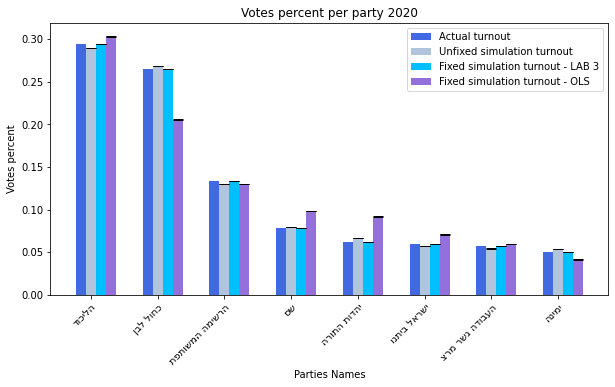

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb269c77198>)

In [44]:
parties_bar(qj, pj_vi, qj_vi_hat_mean, new_qj_vi_hat_mean, sd_pj_vi, sd_qj_vi_fix, sd_qj_vi_new)

ניתן לראות שהתיקון החדש מציג אחוזי הצבעה שונים מאחוזי ההצבעה האמיתיים, בשונה מהתיקון של מעבדה 3 שדווקא תואם לתוצאות האמת. ולכן במקרה זה נעדיף את התיקון ממעבדה 3

**סימולציה ב**

In [45]:
sd_pj_uj = np.std(pj_uj_per,axis =0)
sd_qj_uj_fix = np.std(qj_uj_fix_per,axis =0)
sd_qj_uj_new = np.std(new_qj_uj_per,axis =0)

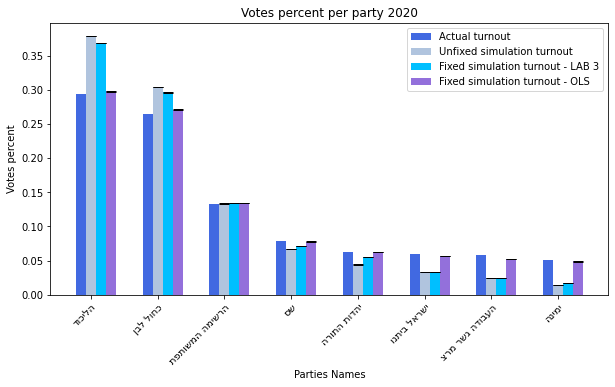

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb2696dff98>)

In [46]:
parties_bar(qj, pj_uj, qj_uj_hat_mean, new_qj_uj_hat_mean, sd_pj_uj, sd_qj_uj_fix, sd_qj_uj_new)

במקרה זה דווקא התיקון החדש מייצג בצורה נכונה יותר את תוצאות האמת, בשונה מהתיקון ממעבדה 3 ולכן במקרה זה נעדיף את התיקון של מודל הרגרסיה

**סימולציה ג**

In [47]:
sd_pj_rnd_uj = np.std(pj_rnd_uj_per,axis =0)
sd_qj_rnd_uj_fix = np.std(qj_rnd_uj_fix_per,axis =0)
sd_qj_rnd_uj_new = np.std(new_qj_rnd_uj_per,axis =0)

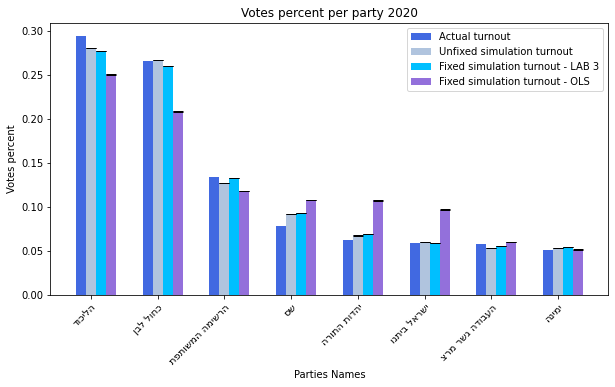

(<Figure size 720x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb2695da5c0>)

In [48]:
parties_bar(qj, pj_rnd_uj, qj_rnd_uj_hat_mean, new_qj_rnd_uj_hat_mean, sd_pj_rnd_uj, sd_qj_rnd_uj_fix, sd_qj_rnd_uj_new)

ניתן לראות שישנן מפלגות שבהן תיקון מודל הרגרסיה יחסית קרוב אבל באחרות הוא רחוק מתוצאות האמת. בשונה מהתיקון ממעבדה 3 שהוא אומד יחסית מדויק יותר ולכן נעדיף את התיקון ממעבדה 3.





באופן כללי ניתן לראות שהאומד ממעבדה 3 מדויק שכן הוא דייק יותר במקרים בהם הנחות ההסתברות היו כלליות ולא קונקרטיות (אחוז הצבעה רנדומלי , או לפי קלפי בלבד).
בנוסף, מכיוון שהאומד החדש היה מדויק רק במקרה בו ההסתברות היתה יחסית לגודל המפלגות, וזו הנה שהיא חזקה מדי אז נעדיף דווקא את האומד הקודם.

# **Q.3**

### **איחוד הנתונים של הבחירות עם המדד החברתי-כלכלי ומציאת יישובים משותפים**

In [49]:
df_2020_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2020.csv']),  encoding = 'iso-8859-8', index_col=['שם ישוב']).sort_index()
df_2020_raw = df_2020_raw.drop(['מעטפות חיצוניות'], axis=0)
df_2020 = df_2020_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
df_2020 = df_2020[df_2020.columns[0:-1]] # removing "metadata" columns
eshkol_hevrati_calcali  = pd.read_csv("Eshkol Hevrati Calcali.csv")

בכדי לאחד את שני מסדי הנתונים על פי הערים המשותפות נבצע

inner join


In [50]:
df_2020.rename(columns={"סמל ישוב":"set_code"}, inplace=True)
join_result = pd.merge(eshkol_hevrati_calcali,df_2020,on="set_code",how="inner")           ## inner join

join_result.shape[0]  

1170

.קיבלנו כי יש 1170 ערים במשותף לשני הקבצים

### **:חישוב אחוזי הצבעה כלליים ואחוזי הצבעה ביישובים שכן במדד**

In [51]:
sum_join_result = join_result.sum(axis=0)
top_par_join = sum_join_result[par_letters]/sum_join_result['כשרים'] 

In [52]:
top_par_join

מחל      0.293319
פה       0.264256
ודעם     0.129106
שס      0.0776491
ג       0.0615037
ל       0.0590187
אמת     0.0572578
טב      0.0501514
dtype: object

**פונקציה להצגת הגרפים**

In [53]:
def bar_plot_2(v1, v2, legend, w,h):
    
    width = 0.25
    n = 8
    rev_names = [name[::-1] for name in list(party_names.values())]
    fig, ax = plt.subplots(figsize=(w,h))  # plt.subplots()

    bar_a = ax.bar(np.arange(n)- width, list(v1), width, color='royalblue')
    bar_b = ax.bar(np.arange(n) , list(v2), width, color='lightsteelblue')


    ax.set_ylabel('Votes percentage')
    ax.set_xlabel('Parties Names')
    ax.set_title('Votes percentage per party 2020' )
    ax.legend((bar_a[0], bar_b[0]), legend)
    ax.set_xticks(np.arange(n))
    plt.setp(ax.get_xticklabels(), rotation=60, ha="right",rotation_mode="anchor")
    ax.set_xticklabels(rev_names)
    plt.show()

    return fig, ax

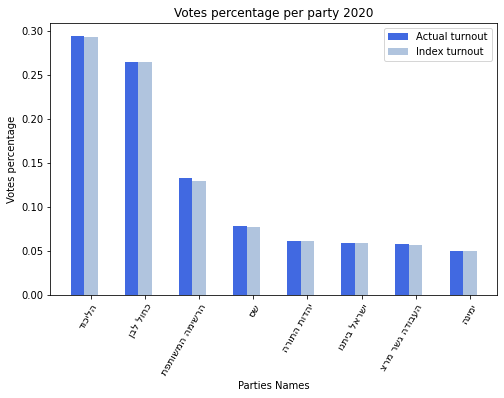

(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb269535860>)

In [54]:
bar_plot_2(qj,top_par_join, legend= ('Actual turnout', 'Index turnout'),w=8, h=5)

 בגרף ניתן לראות שינויים מזעריים מבחינת אחוזים , כלומר רוב היישובים שנכללו באחוזי ההצבעה בפועל נמצאים גם במדד החברתי כלכלי , ולכן גם אחוזי ההצבעה של הישובים שבמדד קרובים מאוד לתוצאות האמת.

**בדיקת התפלגות היישובים שלא נמצאים במדד החברתי-כלכלי**

In [55]:
join_result1 = pd.merge(df_2020, eshkol_hevrati_calcali, on="set_code", how="outer", indicator=True
              ).query('_merge=="left_only"')
not_eshkol = df_2020.loc[df_2020['set_code'].isin(join_result1["set_code"])]
not_eshkol = not_eshkol [['כשרים','מחל', 'פה', 'ודעם', 'שס', 'ג', 'ל', 'אמת', 'טב']]
len(not_eshkol)

43

In [56]:
sum_not_eshkol  = not_eshkol.sum(axis=0)
not_eshkol  = sum_not_eshkol[par_letters]/sum_not_eshkol['כשרים'] 

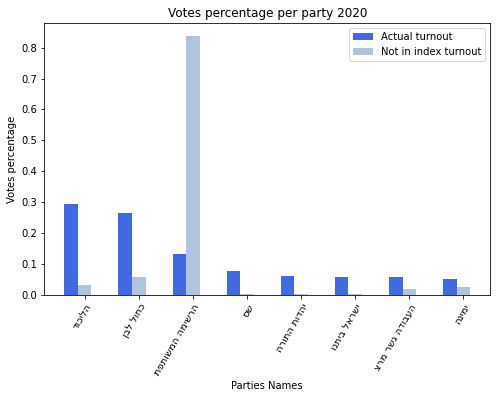

(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb2694115c0>)

In [57]:
bar_plot_2(qj, not_eshkol, legend= ('Actual turnout', 'Not in index turnout'),w=8, h=5)

ניתן לראות שהיישובים שלא מופיעים במדד הכלכלי-חברתי אינם משקפים את אחוז ההצבעה הכללי בתוצאות האמת. בנוסף מכיוון שזה מספר יישובים קטן אז אין לו משקל מרכזי בתוצאות הסופיות.

# **Q.4**

### **סעיף א**

In [58]:
eshkol = []

for i in range(1,11):
  data_new = pd.DataFrame(join_result.where(join_result["eco_level"] == i))
  data_8 = data_new.sum()[par_letters]
  eshkol.append(data_8/data_new.sum()["כשרים"])

<Figure size 432x288 with 0 Axes>

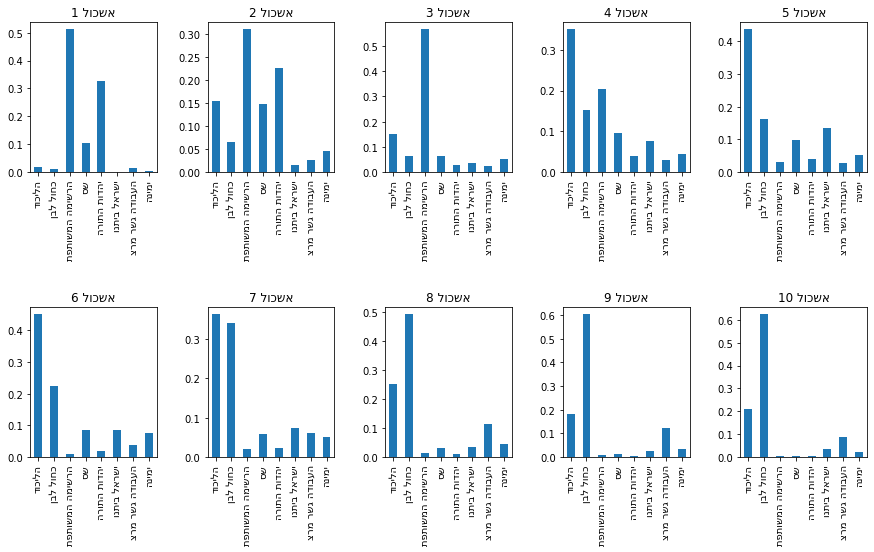

In [59]:
rev_names = [name[::-1] for name in list(party_names.values())]
fig = plt.figure()
fig, axes = plt.subplots(2, 5)
fig.subplots_adjust(hspace = 0.9, wspace = 0.4)

count=0
for r in range(2):
    for c in range(5):
        eshkol[count].plot(figsize=(15,8),ax=axes[r,c],kind = 'bar',title = '{} לוכשא'.format(count+1))
        count += 1

for axes in fig.get_axes():
    axes.set_xticks(range(8))
    axes.set_xticklabels(rev_names,rotation=90,size=10)  

כאשר מסתכלים על אחוזי ההצבעה בחלוקה לאשכולות , ניתן לראות כי בכל אשכול יש נטייה להצביע למפלגות מסויימות. ניקח כדוגמא את כחול לבן - במפלגה זו יש מגמה ברורה לכך שרוב המצביעים של מלפגה זו הם מהאשכולות הגבוהים יותר (החל מאשכול 7).



### **סעיף ב**

In [60]:
party = []

for i in range(8):
  data_new = []
  for j in range(10):
    data_new.append(eshkol[j][i])
  for z in range(10):   
    data_new[z] =data_new[z]/sum(data_new)
  data_new = pd.Series(data_new) 
  data_new.index = [1,2,3,4,5,6,7,8,9,10] 
  party.append(data_new)

<Figure size 432x288 with 0 Axes>

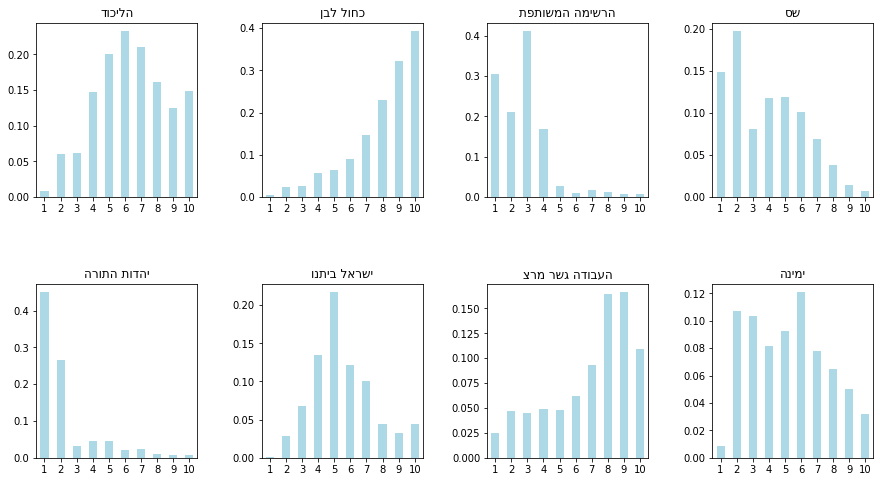

In [61]:
rev_names = [name[::-1] for name in list(party_names.values())]
fig = plt.figure()
fig, axes = plt.subplots(2, 4)
fig.subplots_adjust(hspace = 0.5, wspace = 0.4)

count=0
for r in range(2):
    for c in range(4):
        party[count].plot(figsize=(15,8),ax=axes[r,c],kind = 'bar',title = '{}'.format(rev_names[count]), color = "lightblue")
        count += 1

for axes in fig.get_axes():
    axes.set_xticks(range(10))
    axes.set_xticklabels([1,2,3,4,5,6,7,8,9,10],rotation=0,size=10)

 בדומה לסעיף א , גם כאן ניתן לראות את חלוקת הקולות למפלגות על פי אשכול כלכלי רק באופן מרוכז יותר, כלומר אותה מגמה שתיארנו בסעיף הקודם מופיעה כעת כפונקציה עולה בגרף של כחול לבן.
ניתן כך ללמוד על המצב הסוציואקונומי של התומכים במפלגות השונות.

In [62]:
party_8_join = join_result[['eco_level','מחל', 'פה', 'ודעם', 'שס', 'ג', 'ל', 'אמת', 'טב']]

party_2 = []
sd_par2 = []

for i in range(1,9):
  data_new = []
  sd_data = []
  data_join = party_8_join.iloc[:, [0, i]]
  sum_par = sum(data_join[data_join.columns[-1]])
  for j in range(1,11): 
    esh_data = pd.DataFrame(data_join.loc[data_join["eco_level"] == j])
    sd_data.append(np.std(np.array(esh_data[esh_data.columns[1]]/sum_par)))
    data_new.append(sum(esh_data[esh_data.columns[1]])/sum_par)
  data_new, sd_data = pd.Series(data_new), pd.Series(sd_data)
  data_new.index, sd_data.index = [1,2,3,4,5,6,7,8,9,10] , [1,2,3,4,5,6,7,8,9,10] 
  party_2.append(data_new)
  sd_par2.append(sd_data)

<Figure size 432x288 with 0 Axes>

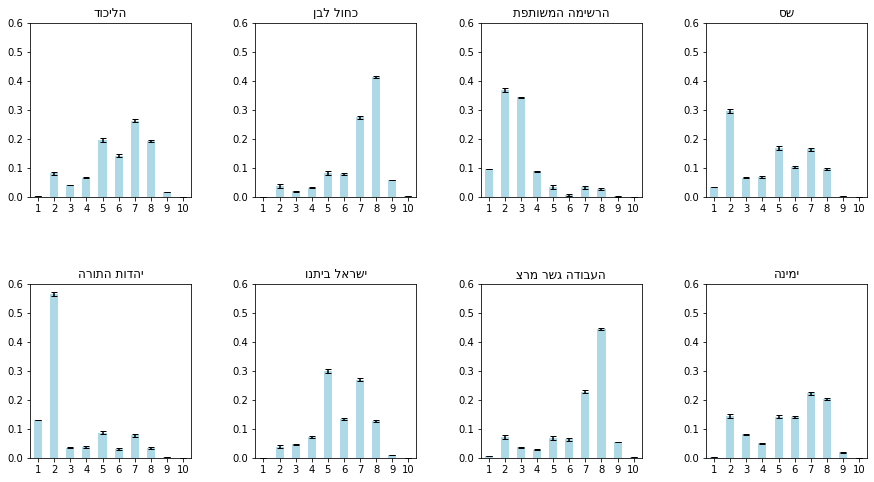

In [63]:
rev_names = [name[::-1] for name in list(party_names.values())]
fig = plt.figure()
fig, axes = plt.subplots(2, 4)
fig.subplots_adjust(hspace = 0.5, wspace = 0.4)

count=0
for r in range(2):
    for c in range(4):
        party_2[count].plot(figsize=(15,8),ax=axes[r,c],kind = 'bar',title = '{}'.format(rev_names[count]),yerr=sd_par2, capsize = 3,color = "lightblue",ylim = [0,0.6])
        count += 1

for axes in fig.get_axes():
    axes.set_xticks(range(10))
    axes.set_xticklabels([1,2,3,4,5,6,7,8,9,10],rotation=0,size=10)

ניתן לראות כאן את התפלגות האשכולות בכל מפלגה ולראות על איזה אשכולות כל מפלגה נשענת יותר. לדוגמה במפלגות החרדיות אחוז גדול מסך הקולות לאותה מפלגה ניתן על ידי אשכול 2, ובעבודה גשר מרץ אותו אחוז ניתן על ידי אשכול 8.

# **EXTRA**

**השוואה בין אשכולות מסויימים**

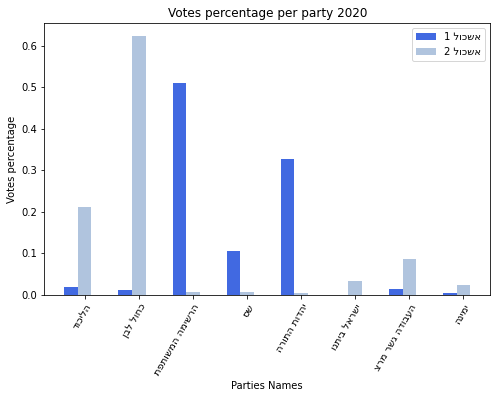

(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb26905c668>)

In [64]:
bar_plot_2(eshkol[0],eshkol[9], legend= ('1 לוכשא', '2 לוכשא'), w= 8,h=5)

אם נסתכל על אשכול 1 מול אשכול 10 , נבחין כי התנהגות המצביעים באשכולות אלו שונה מאוד , ייתכן גם כי שמגמת ההצבעה בין האשכולות היא גם שונה. דבר זה יכול להשפיע על תוצאות הבחירות.

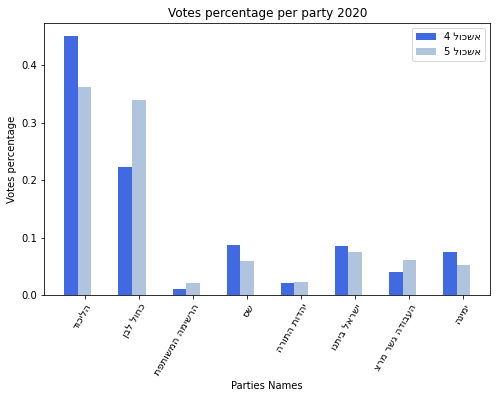

(<Figure size 576x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb2686af470>)

In [65]:
bar_plot_2(eshkol[5],eshkol[6], legend= ('4 לוכשא', '5 לוכשא'), w= 8,h=5)

לעומת זאת, בהסתכלות על ההשוואה בין אשכול 4 לאשכול 5 ניתן לראות שהתפלגות ההצבעה למפלגות מאוד דומה.

ניסינו לבדוק האם יש הבדל בין אחוזי ההצבעה הכלליים בין האשכולות- כלומר האם יש יותר מצביעים מתוך סך הבזב עבור אשכולות מסויימים

In [66]:
eshkol_bzb = []

for i in range(1,11):
  data_new = pd.DataFrame(join_result.where(join_result["eco_level"] == i))
  
  eshkol_bzb.append(data_new["מצביעים"].sum()/data_new["בזב"].sum())
  
eshkol_bzb = pd.Series(eshkol_bzb)
eshkol_bzb.index = [1,2,3,4,5,6,7,8,9,10]  

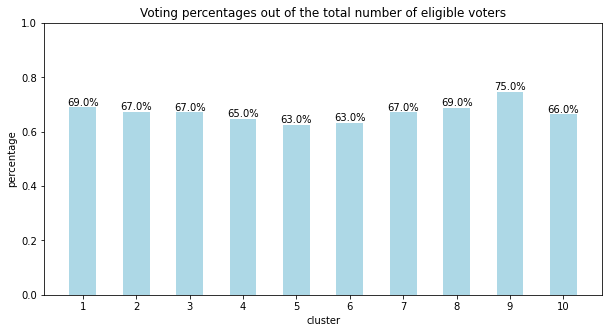

In [67]:
fig, ax = plt.subplots(figsize = (10,5))    
width = 0.5 # the width of the bars 
ind = np.arange(len(eshkol_bzb))  # the x locations for the groups
ax.bar(ind, list(eshkol_bzb), width, color="lightblue")
ax.set_xticks(np.arange(10))
ax.set_xticklabels(eshkol_bzb.index)
plt.ylim(0,1)
ax.set_ylabel('percentage')
ax.set_xlabel('cluster')
ax.set_title('Voting percentages out of the total number of eligible voters' )

rects = ax.patches

for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height,'{}%'.format(((height).round(2))*100) ,
            ha='center', va='bottom')

בגרף זה השוונו את אחוזי ההצבעה בבחירות האחרונות בכל אשכול כלכלי. כפי שניתן לראות אחוזי ההצבעה דומים בכל האשכולות , לכן לא ניתן להסיק כי לאשכול כלכלי מסויים הייתה יותר השפעה על תוצאות הבחירות.